## Descripción
Trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se registran las siguientes observaciones:
* `default`: Variable Binaria. Registra si el cliente entró en morosidad o no
* `income`: Ingreso promedio declarado por el cliente
* `balance`: Total del sando en la cuenta de crédito
* `student`: Variable binaria. Registra si el cliente es estudiante o no.

## Ejercicio 1: Preparación de ambiente de trabajo
* Importe los módulos básicos para el análisis de datos.
* Importe las clases `LabelEncoder`, `StandardScaler` y `LabelBinarizer` de `preprocessing`
* Importe las funciones `train_test_split` y `cross_val_score` de `model_selection`
* Importe la función `classification_report` de `metrics`
* Importe las clases `LinearDiscriminantAnalysis` y `QuadraticDiscriminantAnalysis`.
* Agregue la base de datos en el ambiente de trabajo.
* Inspeccione la distribución de cada atributo


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

import warnings
warnings.simplefilter('ignore')
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('default_credit.csv').drop(columns='index')
df.head()

default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879

In [3]:
df.describe()

balance        income
count  10000.000000  10000.000000
mean     835.374886  33516.981876
std      483.714985  13336.639563
min        0.000000    771.967729
25%      481.731105  21340.462903
50%      823.636973  34552.644802
75%     1166.308386  43807.729272
max     2654.322576  73554.233495

In [4]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


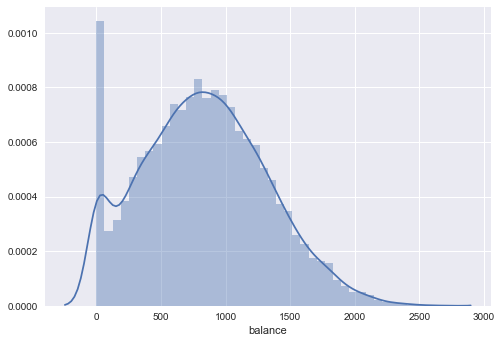

In [5]:
sns.distplot(df['balance']);

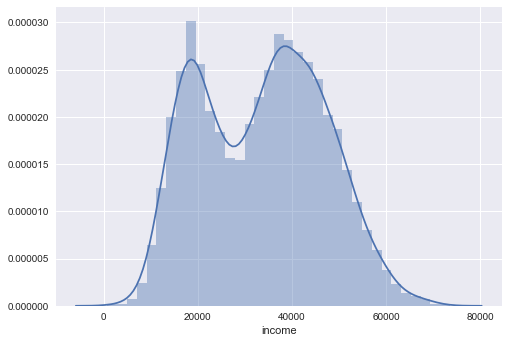

In [6]:
 sns.distplot(df['income']);

No     0.9667
Yes    0.0333
Name: default, dtype: float64


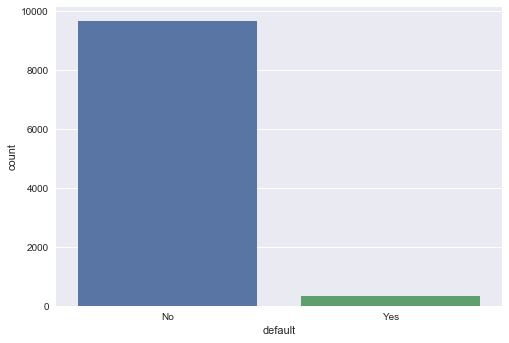

In [7]:
sns.countplot(df['default'])
print(df['default'].value_counts('%'))

No     0.7056
Yes    0.2944
Name: student, dtype: float64


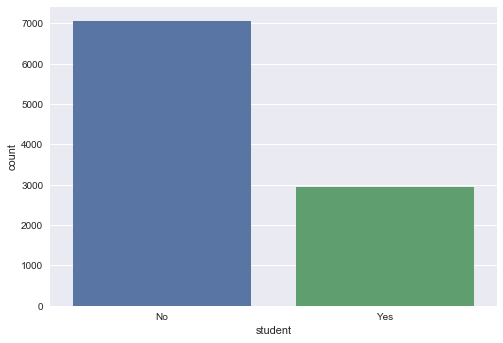

In [8]:
sns.countplot(df['student'])
print(df['student'].value_counts('%'))

## Ejercicio 2: Modelo base
* Recuerde que los modelos de `sklearn` no soportan datos que no sean numéricos. Transforme los atributos pertinentes con `LabelEncoder`
* Genere muestras de validación y entrenamiento, reservando un 33% de los datos como validación.
* Genere un modelo con `LinearDiscriminantAnalysis` sin modificar los hiperparámetros. Genere métricas de evaluación utilizando `classification_report`.
* Comente sobre cuál es el desempeño del modelo en cada clase, así como en general.


In [9]:
df['default'] = LabelEncoder().fit_transform(df['default'])
df['student'] = LabelEncoder().fit_transform(df['student'])

In [10]:
df.sample(10)

default  student      balance        income
191         0        0   697.490957  49476.759599
3578        0        0   916.597959  41432.434498
2465        0        1  1187.358891  24267.396480
6489        0        0   773.172492  50069.208822
8843        0        0  1363.310379  35387.698921
6754        0        0     0.000000  49626.415625
6341        0        0   435.004134  30828.860393
7648        0        0  1213.352955  39344.124026
8196        0        0   602.361702  53800.547209
5440        0        1   251.468194  19373.888018

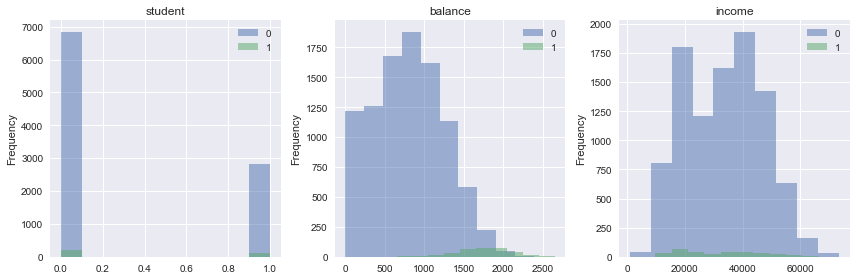

In [11]:
plt.figure(figsize=(12, 4))
for n, i in enumerate(df.drop(columns = 'default').columns):
    plt.subplot(1, 3, n + 1)
    df.groupby('default')[i].plot(kind='hist', alpha=.5)
    plt.legend(df['default'].unique())
    plt.title(i)
    plt.tight_layout()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,'student':'income'],
                                                    df['default'], 
                                                    test_size=.33, 
                                                    random_state=16254) 
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train) 
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
y_hat = lda_model.predict(X_test) 

In [13]:
def plot_class_report(y_test, y_hat, classes_labels, graph=1):
    """
    Retorna las métricas de desempeño por cada clase.

    """
    tmp_report = classification_report(y_test, y_hat, output_dict=True)
    targets = list(classes_labels)
    targets.append('average')
    tmp_report = pd.DataFrame(tmp_report).drop(columns=['weighted avg', 'macro avg'])
    tmp_report.columns = targets
    tmp_report = tmp_report.drop(labels='support')
    tmp_report = tmp_report.drop(columns='average')
    tmp_report = tmp_report.T
    
    if graph==1:
        for index, (colname, serie) in enumerate(tmp_report.iteritems()):
            plt.subplot(len(targets), 1, index + 1)
            serie.plot(kind = 'barh')
            plt.title(f"Métrica: {colname}")
            plt.tight_layout()
    else:
        return tmp_report 

In [14]:
def plot_confusion_matrix(y_test, y_hat, classes_labels):
    """
    Muestra la matriz de confusión por clase.

    """
    color_palette_divergent = LinearSegmentedColormap.from_list('ee', ['#E27872', '#F9F9F8', '#509A9A'])
    color_palette_discrete = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677', '#AA3377', '#BBBBBB']
    color_palette_sequential = [ '#ece3f0', '#d0d1e6', '#a6bddb', '#67a9cf', '#3690c0', '#02818a', '#016c59', '#014636']
    
    tmp_confused = confusion_matrix(y_test, y_hat)
    custom_cmap = LinearSegmentedColormap.from_list('lista', color_palette_sequential)
    sns.heatmap(tmp_confused, annot=True, cbar=False, cmap=custom_cmap, xticklabels=classes_labels,
                yticklabels=classes_labels)
    plt.xlabel('Classes on testing data')
    plt.ylabel('Predicted classes on training')
    plt.grid(False) 

In [15]:
print("Probabilidades a priori\n", lda_model.priors_, "\n")
print("Medias de atributos en cada clase\n",
      lda_model.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n",
      lda_model.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.96626866 0.03373134] 

Medias de atributos en cada clase
 [[2.900000e-01 8.044200e+02 3.347329e+04]
 [3.900000e-01 1.765140e+03 3.194734e+04]] 

Varianza explicada por cada discriminante
 [1.] 



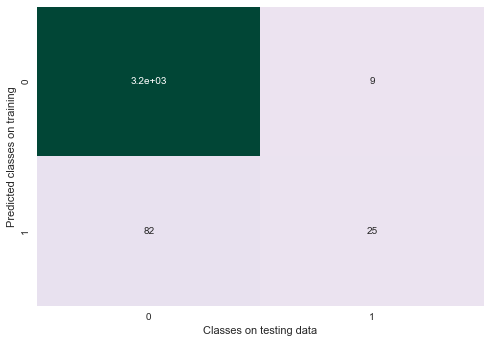

In [16]:
plot_confusion_matrix(y_test, y_hat, df['default'].unique()) 

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3193
           1       0.74      0.23      0.35       107

    accuracy                           0.97      3300
   macro avg       0.86      0.62      0.67      3300
weighted avg       0.97      0.97      0.97      3300



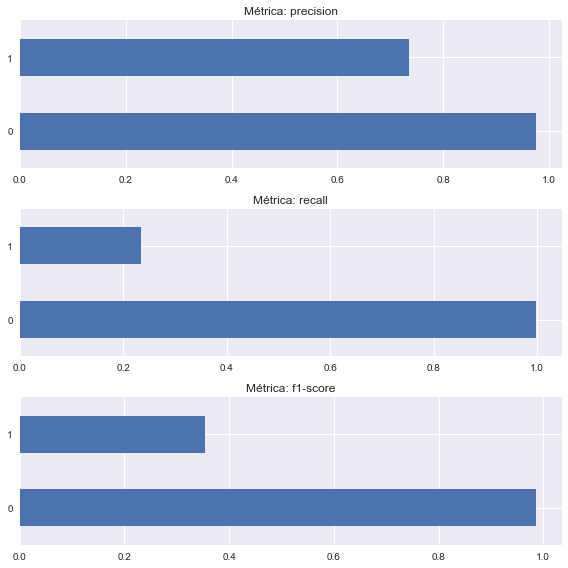

In [17]:
print(classification_report(y_test, y_hat))
plt.figure(figsize=(8, 8))
plot_class_report(y_test, y_hat, classes_labels=df['default'].unique())

**Comentario:** Se busca predecir un cliente tiende a la morosidad. 

Precision es una buena métrica, ya que indica que el modelo predice en un 74% esta condición aun teniendo muy pocos clientes morosos.

## Ejercicio 3: Refactorización 1 - información a priori

* Dado que trabajamos con modelos generativos, podemos incluír información exógena. Para este caso agregaremos dos distribuciones:
* Asumamos que hay un 50/50 de morosos y no morosos.
* Asumamos que hay un 60/40 de morosos y no morosos.
* Por cada modelo, reporte las métricas de clasificación.

In [18]:
priors = [.5, .5]
lda_model_pr_1 = LinearDiscriminantAnalysis(priors=priors)
lda_model_pr_1.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=[0.5, 0.5], shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [19]:
y_hat_pr_1 = lda_model_pr_1.predict(X_test) 

In [20]:
print("Probabilidades a priori\n", lda_model_pr_1.priors_, "\n")
print("Medias de atributos en cada clase\n", lda_model_pr_1.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", lda_model_pr_1.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.5 0.5] 

Medias de atributos en cada clase
 [[2.900000e-01 8.044200e+02 3.347329e+04]
 [3.900000e-01 1.765140e+03 3.194734e+04]] 

Varianza explicada por cada discriminante
 [1.] 



              precision    recall  f1-score   support

           0       1.00      0.85      0.92      3193
           1       0.16      0.88      0.28       107

    accuracy                           0.85      3300
   macro avg       0.58      0.86      0.60      3300
weighted avg       0.97      0.85      0.90      3300



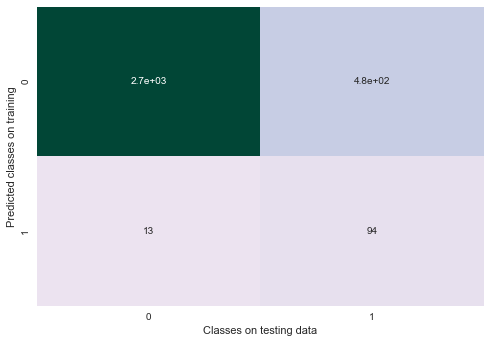

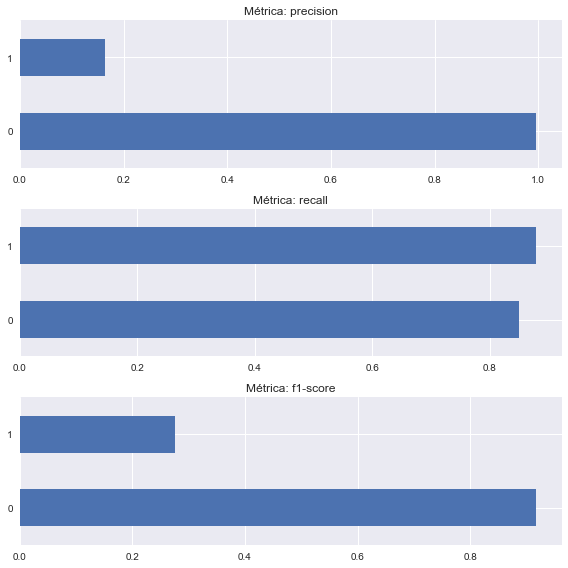

In [21]:
plot_confusion_matrix(y_test, y_hat_pr_1, df['default'].unique())
print(classification_report(y_test, y_hat_pr_1))
plt.figure(figsize=(8, 8))
plot_class_report(y_test, y_hat_pr_1, classes_labels=df['default'].unique())

Mejoran los falsos negativos

In [22]:
priors_2 = [.4, .6]
lda_model_pr_2 = LinearDiscriminantAnalysis(priors=priors_2)
lda_model_pr_2.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=[0.4, 0.6], shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [23]:
lda_model.classes_ 

array([0, 1])

In [24]:
y_hat_pr_2 = lda_model_pr_2.predict(X_test) 

In [25]:
print("Probabilidades a priori\n", lda_model_pr_2.priors_, "\n")
print("Medias de atributos en cada clase\n", lda_model_pr_2.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", lda_model_pr_2.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.4 0.6] 

Medias de atributos en cada clase
 [[2.900000e-01 8.044200e+02 3.347329e+04]
 [3.900000e-01 1.765140e+03 3.194734e+04]] 

Varianza explicada por cada discriminante
 [1.] 



              precision    recall  f1-score   support

           0       1.00      0.80      0.88      3193
           1       0.13      0.90      0.22       107

    accuracy                           0.80      3300
   macro avg       0.56      0.85      0.55      3300
weighted avg       0.97      0.80      0.86      3300



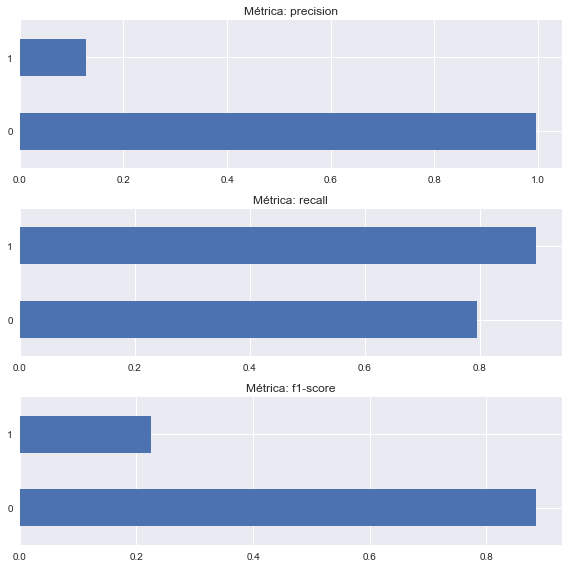

In [26]:
print(classification_report(y_test, y_hat_pr_2))
plt.figure(figsize=(8, 8))
plot_class_report(y_test, y_hat_pr_2, classes_labels=df['default'].unique())

Mejora un poco el recall pero la prediccion es mala

## Ejercicio 4: Refactorización 2 - oversampling

Digresión: Synthetic Over(Under)Sampling
* Por lo general podemos intentar aliviar el problema del desbalance de clases mediante la ponderación dentro del algoritmo. Otra alternativa es el muestreo con reemplazo dentro de los conjuntos de entrenamiento. Estos métodos clásicos se conocen como Oversampling cuando repetimos registros aleatorios de la clase minoritaria, y Undersampling cuando eliminamos aleatoriamente registros de la clase mayoritaria.
* Un contratiempo de estos métodos clásicos es que pueden replicar información sesgada que afecte el desempeño de generalización del modelo. Si los datos son malos, estaremos replicando estas fallas.
* Otra solución es generar ejemplos de entrenamiento sintéticos mediante el entrenamiento de ejemplos de la clase minoritaria. A grandes rasgos la solución funciona de la siguiente forma: En función a un subconjunto de datos correspondientes a la case minoritaria, entrenamos algún modelo no supervisado o generativo como Naive Bayes, KMeans o KNearestNeighbors para generar representaciones sintéticas de los datos en el espacio de atributos de la clase específica mediante [no pude generar este latex]


* Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre clases. Ahora generaremos observaciones sintéticas mediante __SMOTE__ (Synthetic Minority Oversampling Technique). Para ello, debemos agregar el paquete a nuestro ambiente virtual. En nuestro terminal agregamos `conda install -c conda-forge imbalanced-learn`. Incorpore SMOTE en el ambiente de trabajo con la siguiente sintáxis `from imblearn.over_sampling import SMOTE`

* Para implementar oversampling, debemos generar nuevos objetos que representan nuestra muestra de entrenamiento incrementada artificialmente. Para ello implemente la siguiente sintáxis:
    ```python
    from imblearn.over_sampling import SMOTE
    # Instanciamos la clase
    oversampler = SMOTE(random_state=11238, ratio='minority')
    # generamos el eversampling de la matriz de entrenamiento y
    X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)
    ```
   
* Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente sobre su desempeño.

In [27]:
 # Aplicamos oversampler
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=16254, sampling_strategy='minority')
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)



Observación. respectio a la indicación del desafío al momento de ejecutar esto cambia la forma de instanciar minority la cual puede ser k=5 o con el parametro sampling_strategy

In [28]:
lda_model_oversamp = LinearDiscriminantAnalysis()
lda_model_oversamp.fit(X_train_oversamp, y_train_oversamp)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [29]:
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [30]:
y_hat_oversamp = lda_model_oversamp.predict(X_test) 

In [31]:
print("Probabilidades a priori\n", lda_model_oversamp.priors_, "\n")
print("Medias de atributos en cada clase\n", lda_model_oversamp.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", lda_model_oversamp.explained_variance_ratio_.round(2), "\n") 

Probabilidades a priori
 [0.5 0.5] 

Medias de atributos en cada clase
 [[2.900000e-01 8.044200e+02 3.347329e+04]
 [3.200000e-01 1.766970e+03 3.197242e+04]] 

Varianza explicada por cada discriminante
 [1.] 



              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3193
           1       0.17      0.87      0.28       107

    accuracy                           0.85      3300
   macro avg       0.58      0.86      0.60      3300
weighted avg       0.97      0.85      0.90      3300



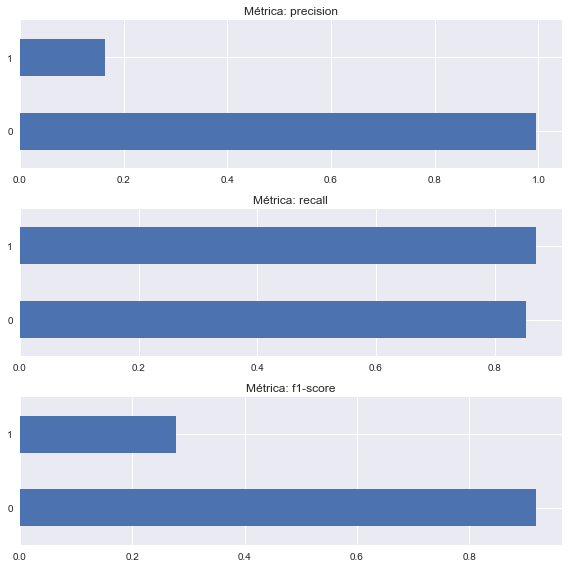

In [32]:
print(classification_report(y_test, y_hat_oversamp))
plt.figure(figsize=(8, 8))
plot_class_report(y_test, y_hat_oversamp, classes_labels=df['default'].unique()) 

Este modelo nos sirve bien para saber quienes no son morosos. Funciona bien para este caso

## Ejercicio 5: Refactorización 3 - QDA
* Por último, implemente un modelo `QuadraticDiscriminantAnalysis` con los datos aumentados artificialmente. Genere las métricas de desempeño.
* Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.

In [33]:
qda_model = QuadraticDiscriminantAnalysis().fit(X_train_oversamp, y_train_oversamp)
y_hat_qda = qda_model.predict(X_test)

Probabilidades a priori
 [0.5 0.5] 

Medias de atributos en cada clase
 [[2.900000e-01 8.044200e+02 3.347329e+04]
 [3.200000e-01 1.766970e+03 3.197242e+04]] 

Varianza explicada por cada discriminante
 [1.] 

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3193
           1       0.17      0.87      0.28       107

    accuracy                           0.85      3300
   macro avg       0.58      0.86      0.60      3300
weighted avg       0.97      0.85      0.90      3300



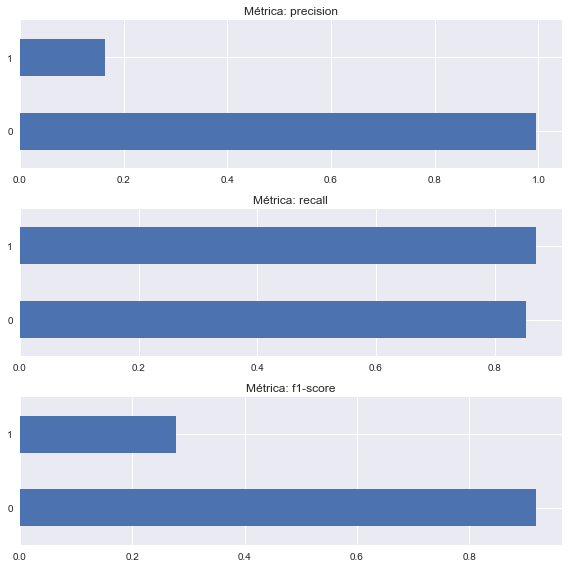

In [34]:
print("Probabilidades a priori\n", lda_model_oversamp.priors_, "\n")
print("Medias de atributos en cada clase\n", lda_model_oversamp.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", lda_model_oversamp.explained_variance_ratio_.round(2), "\n")
print(classification_report(y_test, y_hat_oversamp))
plt.figure(figsize=(8, 8))
plot_class_report(y_test, y_hat_oversamp, classes_labels=df['default'].unique())

El resultado es casi igual al segundo modelo.

En este caso, el modelo 1 predice mejor nuestro vector objetivo